In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Mounted at /content/gdrive
/content/gdrive/My Drive/Pytorch-Models


In [2]:
import torch
import os

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


Setup complete. Using torch 2.9.0+cu126 (Tesla T4)


In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)

        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)

        return image, target

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Returns a simple transform that converts a PIL image to a PyTorch tensor
def get_transform():
    return Compose([
        ToTensor(),  # Convert PIL image to tensor
    ])

# Load training dataset with transform applied
train_dataset = CocoDetectionDataset(
    image_dir="datasets/markerpens/train",
    annotation_path="datasets/markerpens/train/_annotations.coco.json",
    transforms=get_transform()
)

# Load validation dataset with same transform
val_dataset = CocoDetectionDataset(
    image_dir="datasets/markerpens/valid",
    annotation_path="datasets/markerpens/valid/_annotations.coco.json",
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=3.09s)
creating index...
index created!
loading annotations into memory...
Done (t=1.63s)
creating index...
index created!


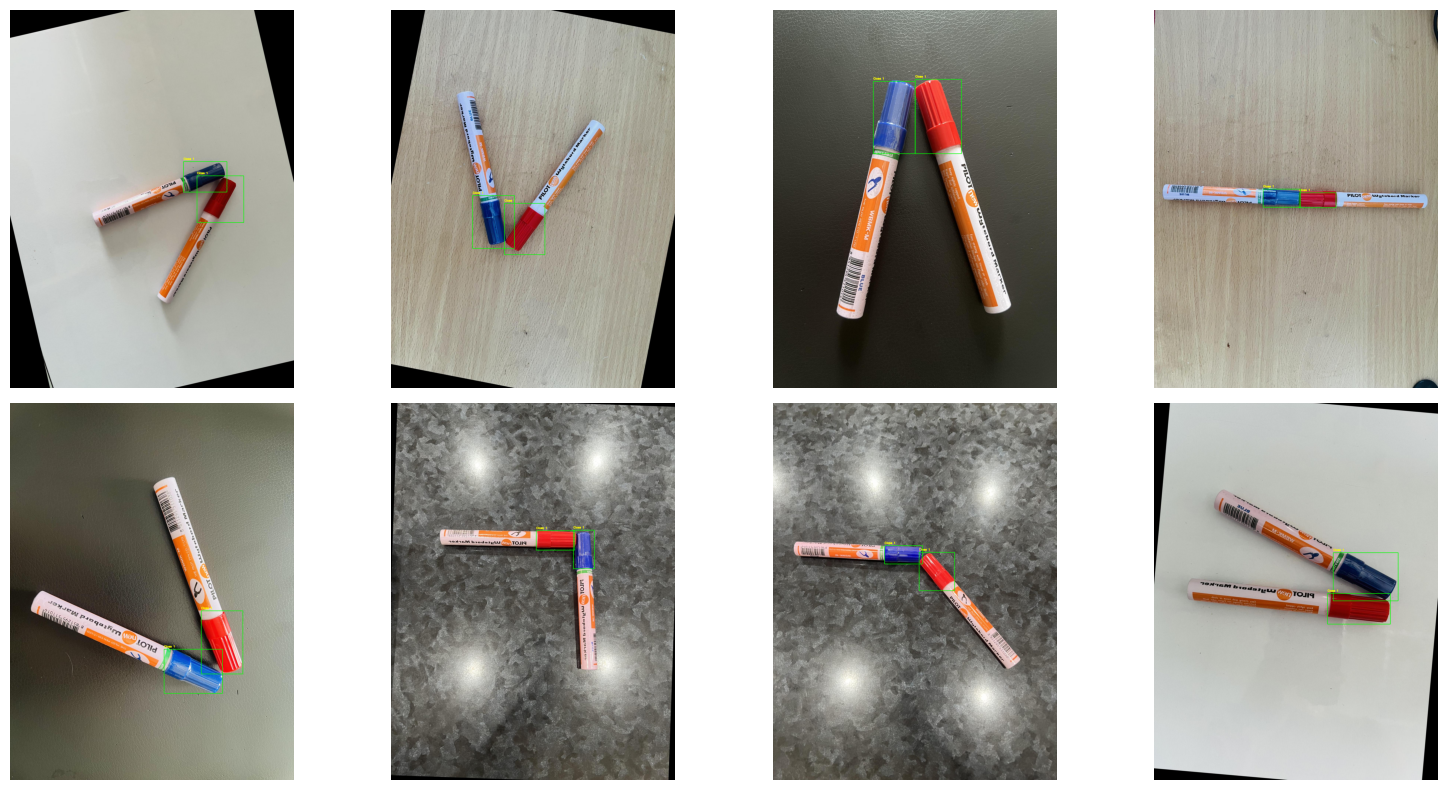

In [7]:
# Get one batch from the DataLoader
images, targets = next(iter(train_loader))

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

plt.figure(figsize=(4 * cols, 4 * rows))

# Convert PIL Image and draw annotations
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    image = (image * 255).astype(np.uint8)  # Rescale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    boxes = targets[i]['boxes']
    labels = targets[i]['labels']

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Show image with boxes using matplotlib
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from functools import partial

# Step 1: Load pretrained model
model = retinanet_resnet50_fpn_v2(pretrained=True)

# Step 2: Define your number of classes (including background)
num_classes = 2  # e.g., 4 classes + 1 background

# Step 3: Extract in_channels and num_anchors from the existing model
num_anchors = model.head.classification_head.num_anchors

# Step 4: Replace classification head with custom number of classes
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=256,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=partial(torch.nn.GroupNorm, 32)
)
# Move the model to the specified device (GPU or CPU)
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


100%|██████████| 146M/146M [00:00<00:00, 200MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [9]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)

In [10]:
# Clone the PyTorch vision repository
!git clone https://github.com/pytorch/vision.git

# Navigate to the 'vision' directory and copy necessary detection-related utility files
!cd vision; cp references/detection/utils.py ../;  # Copy utility functions
!cd vision; cp references/detection/transforms.py ../;  # Copy image transformation functions
!cd vision; cp references/detection/coco_eval.py ../;  # Copy COCO evaluation script
!cd vision; cp references/detection/engine.py ../;  # Copy engine code for training/evaluation
!cd vision; cp references/detection/coco_utils.py ../;  # Copy COCO-specific utility functions

fatal: destination path 'vision' already exists and is not an empty directory.


In [11]:
def compute_iou(box1, box2):
    # box1: [x1, y1, x2, y2], box2: same
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

In [12]:
def evaluate_precision_recall(model, dataloader, device, iou_threshold=0.5, conf_threshold=0.2):
    model.eval()
    TP = 0
    FP = 0
    FN = 0

    with torch.no_grad():
        for images, targets in dataloader:
            # ✅ Move to same device as model
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, gt in zip(outputs, targets):
                pred_boxes = pred["boxes"].cpu()
                pred_scores = pred["scores"].cpu()
                pred_labels = pred["labels"].cpu()

                gt_boxes = gt["boxes"].cpu()
                gt_labels = gt["labels"].cpu()

                matched_gt = set()

                for i, (pb, ps, pl) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
                    if ps < conf_threshold:
                        continue
                    found_match = False
                    for j, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                        if j in matched_gt or pl != gl:
                            continue
                        iou = compute_iou(pb, gb)
                        if iou >= iou_threshold:
                            TP += 1
                            matched_gt.add(j)
                            found_match = True
                            break
                    if not found_match:
                        FP += 1

                FN += len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    model.train()

In [13]:
from engine import train_one_epoch

# Set the number of epochs for training
num_epochs = 30

# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate_precision_recall(model, val_loader, device)

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


Epoch 1/30


/content/gdrive/MyDrive/Pytorch-Models/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/29]  eta: 0:06:05  lr: 0.000004  loss: 1.4201 (1.4201)  classification: 1.1125 (1.1125)  bbox_regression: 0.3076 (0.3076)  time: 12.6034  data: 8.1952  max mem: 10028
Epoch: [0]  [25/29]  eta: 0:00:11  lr: 0.000093  loss: 0.5071 (0.8354)  classification: 0.3484 (0.6143)  bbox_regression: 0.1839 (0.2211)  time: 2.6310  data: 0.5217  max mem: 10381
Epoch: [0]  [28/29]  eta: 0:00:02  lr: 0.000100  loss: 0.4636 (0.7800)  classification: 0.2982 (0.5685)  bbox_regression: 0.1587 (0.2115)  time: 2.4844  data: 0.4824  max mem: 10381
Epoch: [0] Total time: 0:01:23 (2.8739 s / it)
Precision: 0.3468, Recall: 1.0000

Epoch 2/30
Epoch: [1]  [ 0/29]  eta: 0:01:48  lr: 0.000100  loss: 0.3185 (0.3185)  classification: 0.2020 (0.2020)  bbox_regression: 0.1165 (0.1165)  time: 3.7346  data: 1.5345  max mem: 10381
Epoch: [1]  [25/29]  eta: 0:00:09  lr: 0.000100  loss: 0.2081 (0.2345)  classification: 0.0802 (0.1047)  bbox_regression: 0.1256 (0.1298)  time: 2.2332  data: 0.0906  max mem: 10

In [14]:
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

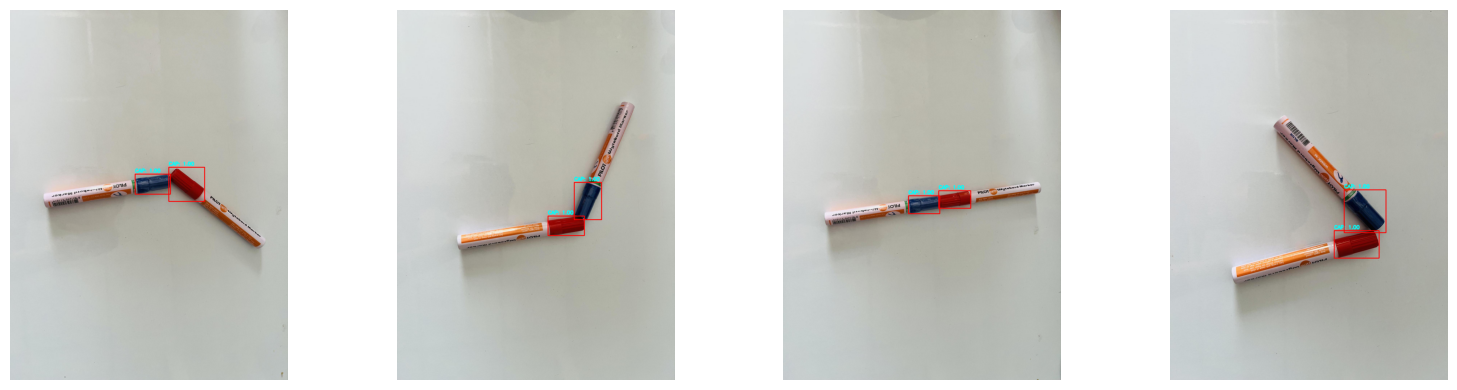

In [19]:
# class names
label_list= ["","CAP"]

# Step 1: Load pretrained model
model = retinanet_resnet50_fpn_v2(pretrained=False)

# Step 2: Define your number of classes (including background)
num_classes = 2  # e.g., 4 classes + 1 background

# Step 3: Extract in_channels and num_anchors from the existing model
num_anchors = model.head.classification_head.num_anchors

# Step 4: Replace classification head with custom number of classes
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=256,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=partial(torch.nn.GroupNorm, 32)
)
"""
Change this to your model path
"""
model.load_state_dict(torch.load(r"model_epoch_21.pth"))
model.eval()

# ---------------- CONFIG ----------------
val_dir = "test/images/"

# visualization layout
N = 4
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(sample_imgs):
    plt.subplot(1, 4, i+1)

    image_bgr = cv2.imread(image)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Transform image
    transform = Compose([
            ToTensor(),  # Convert PIL image to tensor
        ])
    image_tensor = transform(image_pil).unsqueeze(0)

    # Inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Parse predictions
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    # Threshold
    threshold = 0.2
    for ii in range(len(boxes)):
        if scores[ii] > threshold:
            box = boxes[ii].cpu().numpy().astype(int)
            label = label_list[labels[ii]]
            score = scores[ii].item()

            # draw label and score
            text = f"{label}: {score:.2f}"
            cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (255, 255, 0), 3, cv2.LINE_AA)

            # Draw rectangle and label
            cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 3)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
model.to(device)
evaluate_precision_recall(model, val_loader, device)

Precision: 0.9677, Recall: 1.0000


In [24]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 16.0 MB/s eta 0:00:00


In [37]:
dummy_input = torch.randn(1, 3, 640, 640).to(device)
onnx_model_path = "retinanet_det.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    opset_version=13,
    dynamo=False,        # Use legacy exporter to avoid strict tracing issues
    input_names=["input"],
    output_names=["boxes", "labels", "scores"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "boxes": {0: "num_boxes"},
        "labels": {0: "num_boxes"},
        "scores": {0: "num_boxes"},
    },
    do_constant_folding=True,
)
print(f"ONNX export {onnx_model_path} completed successfully!")

/tmp/ipython-input-1879611869.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:4701: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(scale_factors[i], dtype=torch.float32)
/usr/local/lib/python3.12/dist-packages/tor

ONNX export retinanet_det.onnx completed successfully!


In [29]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 5.7 MB/s eta 0:00:00


In [51]:
import onnxruntime
import numpy as np
import cv2
import torch

# Load image and preprocess (assume 640x640)
img_path = "test/images/1B3246F6-8785-4465-AC56-3BE7AA44003D_jpeg.rf.42ad4544fea633e89b87fdf8b4bf9d0c.jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (640, 640))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("retinanet_det.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

# outputs is a list, often like [boxes, scores, keypoints]
print("Output:", [o.shape for o in outputs])

Output: [(6, 4), (6,), (6,)]


[1 1 1 1 1 1]
[0.99972576 0.9832947  0.16860169 0.15018243 0.12770194 0.07049209]


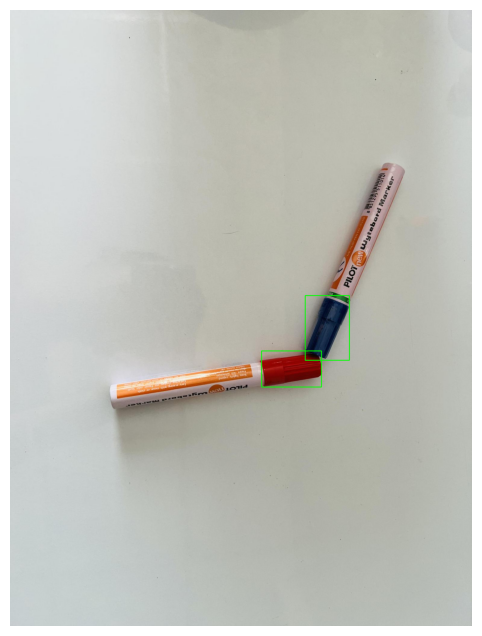

In [52]:
import torch
from torchvision.ops import nms
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Unpack outputs correctly
boxes, scores, labels = outputs

# Convert to numpy arrays if needed
boxes = np.array(boxes)
labels = np.array(labels)
scores = np.array(scores)

# Apply NMS
boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
scores_tensor = torch.tensor(scores, dtype=torch.float32)
nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

# Filter after NMS
boxes = boxes_tensor[nms_indices].numpy()
scores = scores_tensor[nms_indices].numpy()
print(labels)
print(scores)

# Resize back to original scale
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / 640  # width scale
scale_y = h_orig / 640  # height scale

conf_thr = 0.5

for i in range(len(scores)):
    if scores[i] < conf_thr:
        continue

    # Draw bounding box
    x1, y1, x2, y2 = boxes[i]
    x1 = int(x1 * scale_x)
    y1 = int(y1 * scale_y)
    x2 = int(x2 * scale_x)
    y2 = int(y2 * scale_y)

    x1 = max(0, min(x1, w_orig - 1))
    y1 = max(0, min(y1, h_orig - 1))
    x2 = max(0, min(x2, w_orig - 1))
    y2 = max(0, min(y2, h_orig - 1))

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

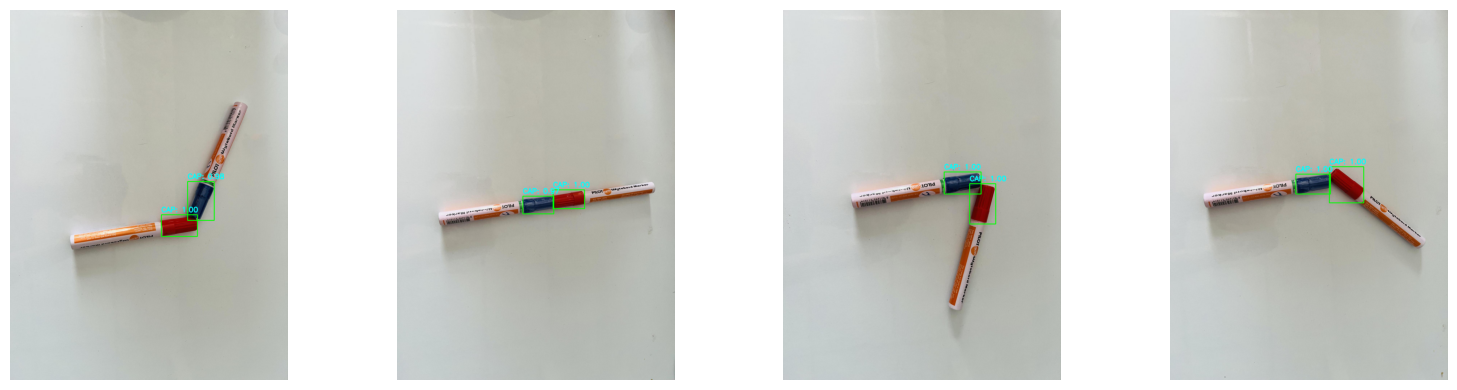

In [55]:
# class names
label_list= ["","CAP"]

session = onnxruntime.InferenceSession("retinanet_det.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name

# ---------------- CONFIG ----------------
val_dir = "test/images/"

# visualization layout
N = 4
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(sample_imgs):
    plt.subplot(1, 4, i+1)

    img = cv2.imread(image)
    img_resized = cv2.resize(img, (640, 640))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

    outputs = session.run(None, {input_name: img_input})

    boxes, scores, labels = outputs

    # Convert to numpy arrays if needed
    boxes = np.array(boxes)
    labels = np.array(labels)
    scores = np.array(scores)

    # Apply NMS
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

    # Filter after NMS
    boxes = boxes_tensor[nms_indices].numpy()
    scores = scores_tensor[nms_indices].numpy()

    # Resize back to original scale
    h_orig, w_orig = img.shape[:2]
    scale_x = w_orig / 640  # width scale
    scale_y = h_orig / 640  # height scale

    conf_thr = 0.5

    for ii in range(len(scores)):
        if scores[ii] < conf_thr:
            continue

        label = label_list[labels[ii]]
        score = scores[ii]

        # Draw bounding box
        x1, y1, x2, y2 = boxes[ii]
        x1 = int(x1 * scale_x)
        y1 = int(y1 * scale_y)
        x2 = int(x2 * scale_x)
        y2 = int(y2 * scale_y)

        x1 = max(0, min(x1, w_orig - 1))
        y1 = max(0, min(y1, h_orig - 1))
        x2 = max(0, min(x2, w_orig - 1))
        y2 = max(0, min(y2, h_orig - 1))

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # draw label and score
        text = f"{label}: {score:.2f}"
        cv2.putText(img, text, (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX,
                    1.3, (255, 255, 0), 3, cv2.LINE_AA)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()